# Análisis de la vida académica de la Facultad de Ciencias
## Indicadores de Profesores de Asignatura

### Carga de librerías para el análisis 

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import matplotlib.pyplot as plt

### Cargar bases de datos que utilizaremos

In [3]:
df_courses=pd.read_csv('../Data/courses.csv', dtype = {'ID': str,'CourseName': str}).set_index('ID')

df_groups=pd.read_csv('../Data/groups.csv', dtype = {'GroupYSID': str,'Quota': int,'Signed':int}).set_index('GroupYSID')

df_profs=pd.read_csv('../Data/profs-anon.csv', dtype = {'ID': int, 'Name':str, 'Appointment':str,'SimpAppointment': 'category'}).set_index('ID')

df_teaching=pd.read_csv('../Data/teaching.csv', dtype = {'ProfID': int,'GroupYSID': str,'ProfType':'category', 'Days': str, 'Hours': str})

df_plans=pd.read_csv('../Data/plans_courses.csv', dtype={'CourseID':int,'PlanID':str,'CourseType':'category'})

df_plan_names=pd.read_csv('../Data/plans.csv')

# Hay algunas materias homólogas que no queremos que estén
df_homologas=pd.read_csv('../Data/homologas.csv')
df_homologas['old_name_code']=df_homologas['old_name_code'].apply(lambda x: '{:0>4d}'.format(x))
df_homologas['new_name_code']=df_homologas['new_name_code'].apply(lambda x: '{:0>4d}'.format(x))

In [4]:
for df in [df_courses, df_groups, df_profs, df_teaching, df_plans]:
    display(df.sample(3))

,CourseName
ID,
0282,Historia de la Física I
2026,Temas Selectos de Relatividad
0263,Temas Selectos de Tecnologías de Vacío II


,Quota,Signed
GroupYSID,,
2001-1-0045-2104,3,3
2002-1-0104-8022,19,19
2008-2-0203-3022,0,7


,Appointment,SimpAppointment
ID,,
72465,Ayudante de Profesora de Asignatura,Ayud
20909,Profesora de Asignatura,PA
30074,Ayudante de Profesor de Asignatura,Ayud


,ProfID,GroupYSID,ProfType,Days,Hours
20419,32868,2010-1-1503-5376,Profesor,ma,15 a 15:45
110820,61509,2010-2-1214-2001,Profesor,NaN,NaN
72682,41330,2018-2-1800-5442,Profesor,NaN,NaN


,CourseID,PlanID,CourseType
526,130,122,Optativa
417,178,106,Optativa
815,1734,134,Obligatoria


### Agregar funciones útiles

In [5]:
def get_course_name(courseid):
    try:
        if type(courseid)==int:
            courseid='{:0>4d}'.format(courseid)
        if type(courseid)==str:
            return(df_courses.loc[courseid]['CourseName'])
    except:
        return "Not found"
    
def es_asignatura(text):
    if text=='PA':
        return(1)
    else:
        return(0)

### Agregar columnas útiles

Para `df_teaching`

In [6]:
df_teaching['CourseID']=df_teaching['GroupYSID'].apply(lambda x: x.split('-')[-2])
df_teaching['Semester']=df_teaching['GroupYSID'].apply(lambda x:x[:6])
df_teaching['CourseName']=df_teaching['CourseID'].apply(get_course_name)
display(df_teaching['CourseID'].head())
display(df_teaching['Semester'].head())
display(df_teaching['CourseName'].head())

0    2017
1    0307
2    0827
3    0302
4    0302
Name: CourseID, dtype: object

0    2016-1
1    2006-2
2    2008-1
3    2007-1
4    2007-2
Name: Semester, dtype: object

0                          Meteorología
1    Máquinas Digitales con Laboratorio
2        Dinámica de Medios Deformables
3                  Fenómenos Colectivos
4                  Fenómenos Colectivos
Name: CourseName, dtype: object

Para `df_profs`

In [7]:
df_profs['Asignatura']=df_profs['SimpAppointment'].apply(es_asignatura)

### Tipos de semestre

In [8]:
sem_1=['{}-1'.format(j) for j in range(2001,2022)]
sem_2=['{}-2'.format(j) for j in range(2001,2022)]
sem_3=['{}-3'.format(j) for j in range(2001,2022)]
sem_4=['{}-4'.format(j) for j in range(2001,2022)]
sem_regular=sorted(sem_1+sem_2)
sem_inter=sorted(sem_3+sem_4)
sem_1_recent=['{}-1'.format(j) for j in range(2017,2022)]
sem_2_recent=['{}-2'.format(j) for j in range(2017,2022)]
sem_3_recent=['{}-3'.format(j) for j in range(2017,2022)]
sem_4_recent=['{}-4'.format(j) for j in range(2017,2022)]
sem_regular_recent=sorted(sem_1_recent+sem_2_recent)
sem_inter_recent=sorted(sem_3_recent+sem_3_recent)

## Join de la información

In [9]:
df_teaching_join=df_teaching.join(df_groups,on='GroupYSID').join(df_profs, on='ProfID')
df_teaching_join['Asignatura']=df_teaching_join['SimpAppointment'].apply(es_asignatura)
df_teaching_join.head()

# Quitamos las materias homólogas. Dejamos sólo con el nombre reciente.
print(df_teaching_join.shape)
df_teaching_join=df_teaching_join[~df_teaching_join['CourseID'].isin(df_homologas['old_name_code'])]
print(df_teaching_join.shape)

(146660, 13)
(140357, 13)


In [10]:
df_teaching_join.sample(5)

,ProfID,GroupYSID,ProfType,Days,Hours,CourseID,Semester,CourseName,Quota,Signed,Appointment,SimpAppointment,Asignatura
98643,56232,2006-2-0820-7047,Profesor,ma ju,13 a 14:30,0820,2006-2,Robótica,0,6,Profesor de Asignatura,PA,1.0
82268,46504,2018-2-2030-8258,Ayud. Lab.,NaN,NaN,2030,2018-2,Acústica en Fluidos,23,9,Profesor de Asignatura,PA,1.0
40639,33685,2002-1-0422-4139,Ayudante,ma ju,12 a 13,0422,2002-1,Graficas y Juegos,24,25,Ayudante de Profesora de Asignatura,Ayud,0.0
63207,39809,2015-1-1103-5574,Profesor,lu mi vi,8 a 10,1103,2015-1,Matemáticas I,40,43,Profesora de Asignatura,PA,1.0
19800,32845,2021-2-0193-5481,Profesor,ma,7:30 a 10:30,0193,2021-2,Etnofarmacología,30,31,Profesor de Carrera Titular,PTC,0.0


## Histórico asignatura vs. no asignatura

En esta parte estudiamos de manera histórica cuántos grupos han sido atendidos por profesores de asignatura y cuántos por profesores de carrera. De momento nos interesa quién dirige el grupo, de modo que filtramos nuestra información por `ProfType`.

In [11]:
df_teaching_join_prof=df_teaching_join[(df_teaching_join['ProfType']=='Profesor')&(df_teaching_join['Semester'].isin(sem_regular))]
df_teaching_join_prof.sample(5)

,ProfID,GroupYSID,ProfType,Days,Hours,CourseID,Semester,CourseName,Quota,Signed,Appointment,SimpAppointment,Asignatura
111887,61631,2013-1-1603-5456,Profesor,NaN,NaN,1603,2013-1,Taller Nivel 2,0,8,Técnico Académico Titular,Tec,0.0
73325,41363,2014-1-0102-8003,Profesor,vi,7 a 9,0102,2014-1,Computación,0,31,Técnico Académico Asociado,Tec,0.0
74653,42015,2009-2-2075-8233,Profesor,NaN,NaN,2075,2009-2,Temas Selectos de Física Computacional II,0,10,Profesor de Asignatura,PA,1.0
67793,40992,2013-2-1603-5393,Profesor,NaN,NaN,1603,2013-2,Taller Nivel 2,0,0,Técnica Académica Titular,Tec,0.0
133679,76145,2018-1-1625-1147,Profesor,lu mi vi,8 a 10,1625,2018-1,Percepción Remota y Sistemas de Información Ge...,25,22,Técnica Académica Titular,Tec,0.0


Para esta parte sólo nos interesan algunas de las columnas del dataframe.

In [12]:
df_aux=df_teaching_join_prof[['GroupYSID','Asignatura','Semester','Signed']]
df_aux=df_aux.groupby(['GroupYSID']).first().reset_index()
df_aux.head()

,GroupYSID,Asignatura,Semester,Signed
0,2001-1-0001-4114,0.0,2001-1,6
1,2001-1-0001-4115,0.0,2001-1,24
2,2001-1-0001-4116,1.0,2001-1,12
3,2001-1-0001-4117,0.0,2001-1,14
4,2001-1-0001-4118,0.0,2001-1,14


Agrupamos y agregamos para ver cuántos grupos y cuántos estudiantes han antendido profesores de asignatura y profesores de carrera.

In [13]:
df_aux=df_aux.groupby(['Asignatura','Semester']).agg({'GroupYSID':'count','Signed':'sum'})
df_aux=df_aux.unstack(0)
df_aux.head()

GroupYSID      Signed      
Asignatura       0.0  1.0    0.0   1.0
Semester                              
2001-1           438  405   8250  8753
2001-2           403  359   7313  7327
2002-1           438  373   9200  8761
2002-2           455  338   8098  6457
2003-1           496  384   9164  8228

Ahora sí, hacemos las figuras

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


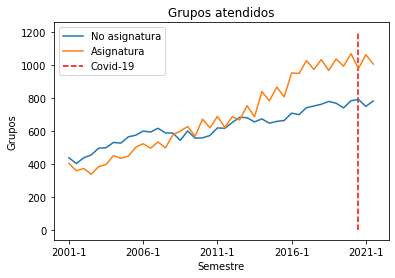

In [14]:
ax = df_aux['GroupYSID'][0].plot(label='No asignatura',title='Grupos atendidos')
df_aux['GroupYSID'][1].plot(ax=ax,label='Asignatura',xlabel='Semestre',ylabel='Grupos')
ax.vlines(39,0,1200,label='Covid-19',color='red',linestyles='dashed')
ax.legend()
plt.savefig('../Figuras/grupos.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


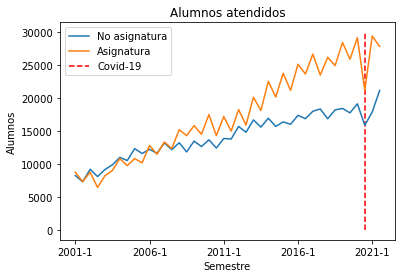

In [15]:
ax = df_aux['Signed'][0].plot(label='No asignatura',title='Alumnos atendidos')
df_aux['Signed'][1].plot(ax=ax,label='Asignatura',xlabel='Semestre',ylabel='Alumnos')
ax.vlines(39,0,30000,label='Covid-19',color='red',linestyles='dashed')
ax.legend()
plt.savefig('../Figuras/alumnos.eps', format='eps')
plt.show()

## Histórico por curso y menor cantidad de asignatura recientes ($\alpha$)

Hacemos un análisis similar, pero restringido a algún curso y sólo para semestres recientes. Esto es sencillo, simplemente hay que elegir el filtro correspondiente. Se puede elegir la materia cambiando el valor de la variable `course_id`.

In [16]:
course_id='0091'
course_name=get_course_name(course_id)
print(course_id,course_name)

0091 Cálculo Diferencial e Integral I


In [17]:
filter_prof=(df_teaching_join['ProfType']=='Profesor')
filter_time=(df_teaching_join['Semester'].isin(sem_regular_recent))
filter_course=(df_teaching_join['CourseID']==course_id)
df_teaching_aux=df_teaching_join[filter_prof&filter_time&filter_course]
df_aux=df_teaching_aux[['GroupYSID','Asignatura','Semester','Signed']]
df_aux=df_aux.groupby(['GroupYSID']).first().reset_index()
df_aux=df_aux.groupby(['Asignatura','Semester']).agg({'GroupYSID':'count','Signed':'sum'})
df_aux=df_aux.unstack(0)
df_aux.head()

GroupYSID       Signed        
Asignatura       0.0   1.0    0.0     1.0
Semester                                 
2017-1          12.0  16.0  875.0   900.0
2017-2           NaN  12.0    NaN   658.0
2018-1           9.0  18.0  549.0  1125.0
2018-2           2.0   9.0  114.0   471.0
2019-1           9.0  23.0  584.0  1253.0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


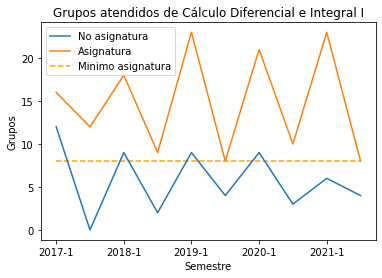

In [18]:
ax = df_aux['GroupYSID'][0].fillna(0).plot(label='No asignatura',title='Grupos atendidos de {}'.format(course_name),xlabel='Semestre',ylabel='Grupos')
df_aux['GroupYSID'][1].fillna(0).plot(ax=ax,label='Asignatura',xlabel='Semestre',ylabel='Grupos')
plt.hlines(df_aux['GroupYSID'][1].fillna(0).min(),0,9,label='Minimo asignatura',linestyles='dashed',color='orange')
ax.legend()
plt.savefig('../Figuras/calculo_grupos.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


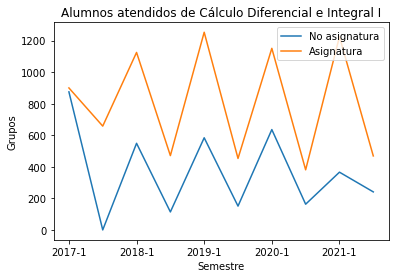

In [19]:
ax = df_aux['Signed'][0].fillna(0).plot(label='No asignatura',title='Alumnos atendidos de {}'.format(course_name),xlabel='Semestre',ylabel='Grupos')
df_aux['Signed'][1].fillna(0).plot(ax=ax,label='Asignatura',xlabel='Semestre',ylabel='Grupos')
ax.legend()
plt.savefig('../Figuras/calculo_alumnos.eps', format='eps')
plt.show()

En general, podemos calcular el valor de $\alpha$ para una materia como sigue:

In [22]:
filter_prof=(df_teaching_join['ProfType']=='Profesor')
filter_time=(df_teaching_join['Semester'].isin(sem_regular_recent))
df_teaching_aux=df_teaching_join[filter_prof&filter_time]

def alpha(course_id):
    df_teaching_aux_loc=df_teaching_aux[df_teaching_aux['CourseID']==course_id]
    df_aux=df_teaching_aux_loc[['GroupYSID','Asignatura','Semester']]
    df_aux=df_aux.groupby(['GroupYSID']).first().reset_index()
    df_aux=df_aux.groupby(['Asignatura','Semester']).agg({'GroupYSID':'count'})
    df_aux=df_aux.unstack(0)
    return df_aux['GroupYSID'][1].fillna(0).min()

In [25]:
alpha("0091")

8.0

## Distribución de impartición ($\beta$)

Para cada profesor de asignatura,¿cuántas veces ha dado un curso? Ya que tenemos eso, ¿cómo se ve la distribución por curso? Una vez más, lo siguiente se puede hacer por asignatura, usando el código de materia en XFC.

In [124]:
course_id='0091'
course_name=get_course_name(course_id)
print(course_id,course_name)

0091 Cálculo Diferencial e Integral I


In [127]:
filter_prof=(df_teaching_join['ProfType']=='Profesor')
filter_time=(df_teaching_join['Semester'].isin(sem_regular_recent))
filter_course=(df_teaching_join['CourseID']==course_id)
filter_asig=(df_teaching_join['Asignatura']==1)

df_teaching_aux=df_teaching_join[filter_prof&filter_time&filter_course&filter_asig]
df_aux=df_teaching_aux[['ProfID','Semester']]
df_aux=df_aux.groupby(['ProfID']).count()
df_aux.head()

,Semester
ProfID,
1987,2
4102,4
6140,2
12138,1
17629,1


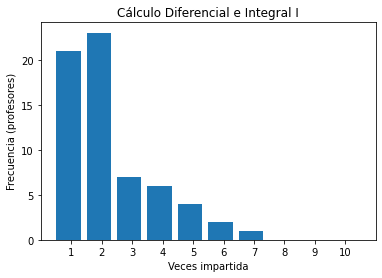

In [145]:
ax=df_aux.plot(kind='hist',bins=np.arange(1,12,1),xticks=np.arange(1,11,1), align='left',width=0.8)
ax.set_xlabel('Veces impartida')
ax.set_ylabel('Frecuencia (profesores)')
ax.set_title('{}'.format(course_name))
ax.get_legend().remove()
plt.savefig('../Figuras/dist_calculo.eps', format='eps')
plt.show()

Para calcular el valor de $\beta$ para una materia, lo que se hace es contar el número de profesores de asignatura que en los últimos 10 semestres han impartido la materia al menos 6 veces.

In [40]:
filter_prof=(df_teaching_join['ProfType']=='Profesor')
filter_time=(df_teaching_join['Semester'].isin(sem_regular_recent))
filter_asig=(df_teaching_join['Asignatura']==1)
df_teaching_aux=df_teaching_join[filter_prof&filter_time&filter_asig]

def beta(course_id):
    filter_course=(df_teaching_aux['CourseID']==course_id)
    df_teaching_aux_loc=df_teaching_aux[filter_course]
    df_aux=df_teaching_aux_loc[['ProfID','Semester']]
    df_aux=df_aux.groupby(['ProfID']).count()
    return(len(df_aux[df_aux['Semester']>=6]))

In [41]:
beta('0091')

3